In [77]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!sudo apt install tesseract-ocr

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,224 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [0]:
!pip install pytesseract

  Created wheel for pytesseract: filename=pytesseract-0.3.4-py2.py3-none-any.whl size=13431 sha256=8dae49618101df6c66dd52b0e15027ac3ce022e49f6eef5c87ea288e9041e1ca
  Stored in directory: /root/.cache/pip/wheels/63/2a/a0/7596d2e0a73cf0aeffd6f6170862c4e73f3763b7827e48691a
Successfully built pytesseract


In [0]:
import argparse
import pytesseract
import cv2
import numpy as np

%matplotlib inline
from matplotlib import pyplot as plt

In [0]:
parser = argparse.ArgumentParser(add_help=False)
parser.add_argument('-f')
parser.add_argument("--image", default='/content/gdrive/My Drive/7.jpg', help="image for prediction")
parser.add_argument("--config", default='/content/gdrive/My Drive/darknet/cfg/yolov3-custom.cfg', help="YOLO config path")
parser.add_argument("--weights", default='/content/gdrive/My Drive/darknet/backup/yolov3-custom_final.weights', help="YOLO weights path")
parser.add_argument("--names", default='/content/gdrive/My Drive/darknet/obj.names', help="class names path")
args = parser.parse_args()

CONF_THRESH, NMS_THRESH = 0.5, 0.5

In [0]:
net = cv2.dnn.readNetFromDarknet(args.config, args.weights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [0]:
layers = net.getLayerNames()
output_layers = [layers[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [0]:
img = cv2.imread(args.image)
height, width = img.shape[:2]

blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
layer_outputs = net.forward(output_layers)

class_ids, confidences, b_boxes = [], [], []
for output in layer_outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]

        if confidence > CONF_THRESH:
            center_x, center_y, w, h = (detection[0:4] * np.array([width, height, width, height])).astype('int')

            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            b_boxes.append([x, y, int(w), int(h)])
            confidences.append(float(confidence))
            class_ids.append(int(class_id))

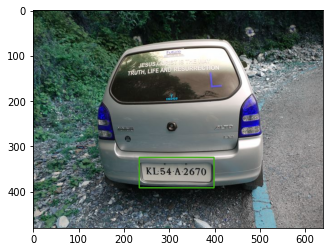

In [81]:
indices = cv2.dnn.NMSBoxes(b_boxes, confidences, CONF_THRESH, NMS_THRESH).flatten().tolist()



# Draw the filtered bounding boxes with their class to the image
with open(args.names, "r") as f:
    classes = [line.strip() for line in f.readlines()]
colors = np.random.uniform(0, 255, size=(len(classes), 3))

for index in indices:
    x, y, w, h = b_boxes[index]
    cv2.rectangle(img, (x, y), (x + w, y + h), colors[index], 2)
    


plt.imshow(img)
plt.show()


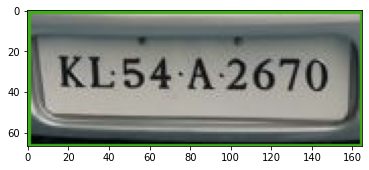

Neco


In [82]:
crop_img= img[y:(y+h),x:(x+w)]

plt.imshow(crop_img)
plt.show()
text = pytesseract.image_to_string(crop_img, lang='eng', config ='--psm 7')
print(text)

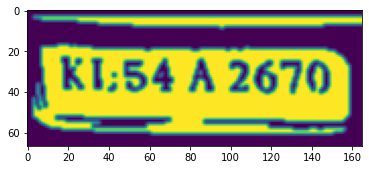

KL54 A 2670


In [85]:

gray = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)

cnts = cv2.findContours(opening, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
for c in cnts:
    area = cv2.contourArea(c)
    if area < 50:
        cv2.drawContours(opening, [c], -1, 0, -1)

# Invert and apply slight Gaussian blur
result = 255 - opening
result = cv2.GaussianBlur(result, (3,3), 0)

# Perform OCR
plt.imshow(result)
plt.show()
data = pytesseract.image_to_string(result, lang='eng', config='--psm 7')
print(data)